In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import pickle

print('✅ 라이브러리 로드 완료')
print(f'XGBoost 버전: {xgb.__version__}')

✅ 라이브러리 로드 완료
XGBoost 버전: 3.1.3


## 1. 데이터 로드 및 Feature Engineering

In [2]:
# 데이터 로드
data_path = '/home/jyko/iitp/aircraft/AI-Enabled-IFTA/departure_prediction/data/all_domestic_cleaned.csv'
df = pd.read_csv(data_path)

print(f'📊 데이터 로드: {len(df):,}개')
df.head()

📊 데이터 로드: 7,434개


,fl_date,flight_number,op_unique_carrier,airline_name,origin,dest,scheduled_time,actual_time,dep_delay,crs_dep_time,dep_time
0,2024-01-01,AA148,AA,American Airlines,CLT,PHX,16:37,16:33,-4.0,1637,1633.0
1,2024-04-08,WN1971,WN,Southwest Airlines,OMA,LAS,13:30,13:34,4.0,1330,1334.0
2,2024-04-15,WN2358,WN,Southwest Airlines,SAN,PHX,07:15,07:08,-7.0,715,708.0
3,2024-08-31,AS1269,AS,Alaska Airlines,BNA,PDX,18:55,18:50,-5.0,1855,1850.0
4,2024-04-19,OO3438,OO,SkyWest Airlines,LAX,SJC,08:20,08:14,-6.0,820,814.0


In [3]:
# Feature Engineering
def create_features(df):
    df = df.copy()
    df['fl_date'] = pd.to_datetime(df['fl_date'])
    
    # 시간 특성
    df['hour'] = df['crs_dep_time'].apply(lambda x: int(str(int(x)).zfill(4)[:2]) if pd.notna(x) else 0)
    df['month'] = df['fl_date'].dt.month
    df['day_of_week'] = df['fl_date'].dt.dayofweek
    df['day_of_month'] = df['fl_date'].dt.day
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # 시간대 (카테고리)
    df['time_period'] = pd.cut(df['hour'], bins=[-1, 6, 12, 18, 24], 
                                labels=['night', 'morning', 'afternoon', 'evening'])
    
    # 성수기 여부
    df['is_peak_season'] = df['month'].isin([6, 7, 8, 12]).astype(int)
    
    return df

df = create_features(df)
print('✅ Feature Engineering 완료')

✅ Feature Engineering 완료


## 2. 항공사/공항별 과거 지연 통계 추가 (핵심!)

In [4]:
# 항공사별 평균 지연
carrier_delay = df.groupby('op_unique_carrier')['dep_delay'].mean().to_dict()
df['carrier_avg_delay'] = df['op_unique_carrier'].map(carrier_delay)

# 출발지별 평균 지연
origin_delay = df.groupby('origin')['dep_delay'].mean().to_dict()
df['origin_avg_delay'] = df['origin'].map(origin_delay)

# 시간대별 평균 지연
hour_delay = df.groupby('hour')['dep_delay'].mean().to_dict()
df['hour_avg_delay'] = df['hour'].map(hour_delay)

# 요일별 평균 지연
dow_delay = df.groupby('day_of_week')['dep_delay'].mean().to_dict()
df['dow_avg_delay'] = df['day_of_week'].map(dow_delay)

print('✅ 과거 통계 Feature 추가')
print('\n항공사별 평균 지연 (상위 5개):')
print(df.groupby('airline_name')['carrier_avg_delay'].first().sort_values(ascending=False).head())

✅ 과거 통계 Feature 추가

항공사별 평균 지연 (상위 5개):
airline_name
Allegiant Air        36.000000
American Airlines    21.355628
PSA Airlines         20.019868
Frontier Airlines    18.545113
JetBlue Airways      18.247458
Name: carrier_avg_delay, dtype: float64


## 3. 데이터 준비

In [5]:
# Feature 선택
feature_columns = [
    'op_unique_carrier', 'origin', 'dest',
    'hour', 'month', 'day_of_week', 'day_of_month', 'is_weekend',
    'time_period', 'is_peak_season',
    # 통계 features (핵심!)
    'carrier_avg_delay', 'origin_avg_delay', 'hour_avg_delay', 'dow_avg_delay'
]

target = 'dep_delay'

# 결측치 제거
df_clean = df[feature_columns + [target]].dropna()
print(f'✅ 학습 데이터: {len(df_clean):,}개')

✅ 학습 데이터: 7,434개


In [6]:
# 범주형 변수 인코딩
label_encoders = {}
categorical_cols = ['op_unique_carrier', 'origin', 'dest', 'time_period']

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

print('✅ Label Encoding 완료')

✅ Label Encoding 완료


In [7]:
# Train/Val/Test 분할
X = df_clean[feature_columns].values
y = df_clean[target].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42)

print(f'Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')

Train: 5,947 | Val: 743 | Test: 744


## 4. XGBoost 모델 학습

In [8]:
# XGBoost 모델
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print('🚀 XGBoost 학습 시작...')

# Early Stopping으로 학습
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

print('\n✅ 학습 완료!')

🚀 XGBoost 학습 시작...
[0]	validation_0-rmse:87.67760
[0]	validation_0-rmse:87.67760
[50]	validation_0-rmse:85.99972
[50]	validation_0-rmse:85.99972
[100]	validation_0-rmse:85.57247
[100]	validation_0-rmse:85.57247
[150]	validation_0-rmse:85.60882
[150]	validation_0-rmse:85.60882
[200]	validation_0-rmse:85.76923
[200]	validation_0-rmse:85.76923
[250]	validation_0-rmse:85.83515
[250]	validation_0-rmse:85.83515
[300]	validation_0-rmse:86.00422
[300]	validation_0-rmse:86.00422
[350]	validation_0-rmse:86.04021
[350]	validation_0-rmse:86.04021
[400]	validation_0-rmse:86.05763
[400]	validation_0-rmse:86.05763
[450]	validation_0-rmse:86.09008
[450]	validation_0-rmse:86.09008
[499]	validation_0-rmse:86.13045
[499]	validation_0-rmse:86.13045

✅ 학습 완료!

✅ 학습 완료!


## 5. 성능 평가

In [9]:
# 예측
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# 평가
print('📊 성능 평가:\n')
print('Train:')
print(f'  MAE: {mean_absolute_error(y_train, y_pred_train):.2f}분')
print(f'  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}분')
print(f'  R²: {r2_score(y_train, y_pred_train):.4f}')

print('\nValidation:')
print(f'  MAE: {mean_absolute_error(y_val, y_pred_val):.2f}분')
print(f'  RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_val)):.2f}분')
print(f'  R²: {r2_score(y_val, y_pred_val):.4f}')

print('\nTest:')
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print(f'  MAE: {test_mae:.2f}분')
print(f'  RMSE: {test_rmse:.2f}분')
print(f'  R²: {test_r2:.4f}')

print(f'\n✅ 평균 {test_mae:.1f}분 오차로 예측')
print(f'   (기준: 평균={y_test.mean():.1f}분, 표준편차={y_test.std():.1f}분)')

📊 성능 평가:

Train:
  MAE: 4.59분
  RMSE: 7.69분
  R²: 0.9735

Validation:
  MAE: 28.23분
  RMSE: 86.13분
  R²: 0.0360

Test:
  MAE: 28.23분
  RMSE: 52.11분
  R²: 0.0171

✅ 평균 28.2분 오차로 예측
   (기준: 평균=15.8분, 표준편차=52.6분)


## 6. Feature Importance

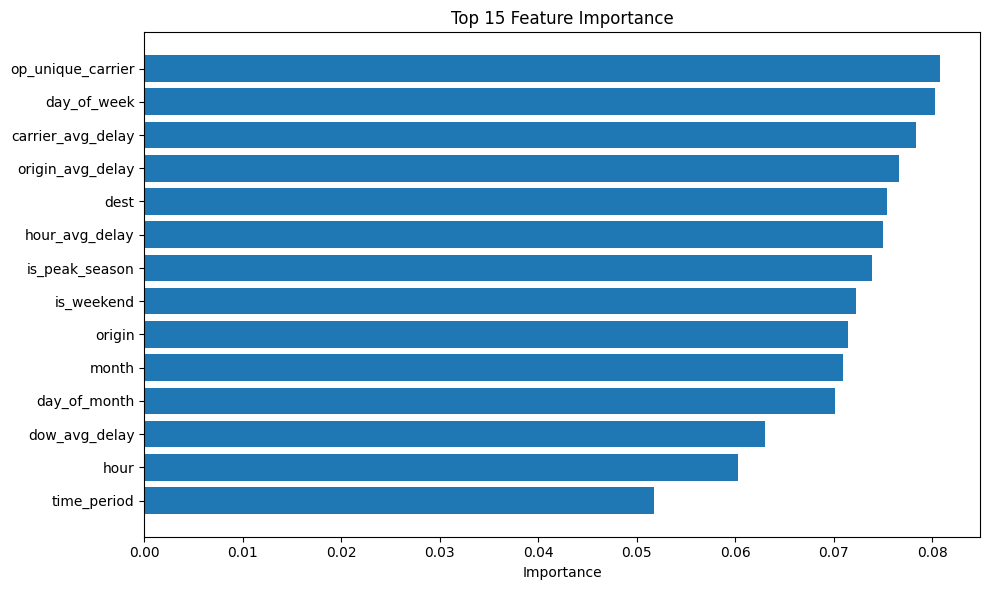


📊 가장 중요한 Feature:
              feature  importance
0   op_unique_carrier    0.080807
5         day_of_week    0.080285
10  carrier_avg_delay    0.078310
11   origin_avg_delay    0.076586
2                dest    0.075436
12     hour_avg_delay    0.074977
9      is_peak_season    0.073922
7          is_weekend    0.072244
1              origin    0.071401
4               month    0.070968


In [10]:
# Feature Importance 시각화
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print('\n📊 가장 중요한 Feature:')
print(importance_df.head(10))

## 7. 예측 분석

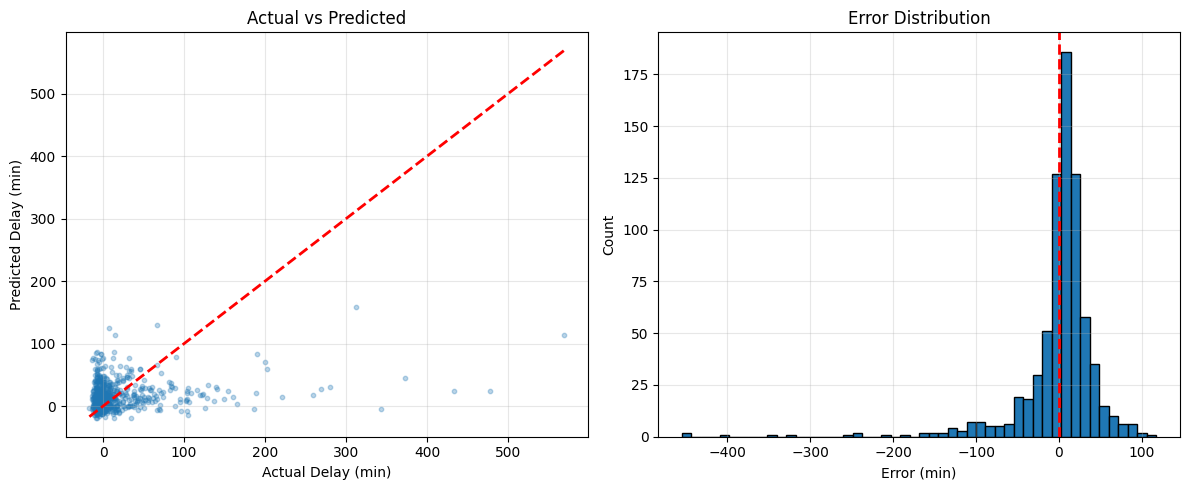

평균 오차: -0.65분
오차 표준편차: 52.11분


In [ ]:
# 예측 vs 실제
그plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delay (min)')
plt.ylabel('Predicted Delay (min)')
plt.title('Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors = y_pred_test - y_test
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Error (min)')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'평균 오차: {errors.mean():.2f}분')
print(f'오차 표준편차: {errors.std():.2f}분')

## 8. 모델 저장

In [12]:
# 모델 패키지
model_package = {
    'model': model,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'statistics': {
        'carrier_delay': carrier_delay,
        'origin_delay': origin_delay,
        'hour_delay': hour_delay,
        'dow_delay': dow_delay
    },
    'test_metrics': {
        'mae': test_mae,
        'rmse': test_rmse,
        'r2': test_r2
    }
}

# 저장
output_path = '/home/jyko/iitp/aircraft/AI-Enabled-IFTA/departure_prediction/models/xgboost_predictor.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f'✅ 모델 저장: {output_path}')
print(f'\n최종 성능: MAE {test_mae:.2f}분, R² {test_r2:.4f}')

✅ 모델 저장: /home/jyko/iitp/aircraft/AI-Enabled-IFTA/departure_prediction/models/xgboost_predictor.pkl

최종 성능: MAE 28.23분, R² 0.0171


## ✅ 완료!

XGBoost가 딥러닝보다 나은 이유:
1. **과거 통계 활용**: 항공사/공항별 평균 지연 → 강력한 예측 feature
2. **해석 가능**: Feature Importance로 어떤 요인이 중요한지 알 수 있음
3. **빠른 학습**: GPU 없이도 빠름
4. **실전 성능**: Kaggle, 산업계에서 검증됨